In [108]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nba_api.stats.endpoints import (
    leaguedashteamstats
)
from nba_api.stats.static import teams

In [109]:
play_types = pd.read_csv('Data/NBA Play Type Data - Sheet1.csv')
print(play_types)


                 TEAM_NAME  ISOLATION FREQ%  TRANSITION FREQ%  P&R FREQ%  \
0       Washington Wizards              4.3              19.4       18.0   
1                Utah Jazz              7.6              17.7       15.0   
2          Toronto Raptors              4.1              21.7       13.5   
3        San Antonio Spurs              6.9              19.9       13.8   
4         Sacramento Kings              7.2              17.4       15.0   
5   Portland Trail Blazers              7.6              18.7       18.0   
6             Phoenix Suns              6.5              15.4       16.4   
7       Philadelphia 76ers              9.4              17.4       17.0   
8            Orlando Magic              7.2              16.4       18.1   
9    Oklahoma City Thunder              9.0              19.3       17.7   
10         New York Knicks              7.3              18.3       15.0   
11    New Orleans Pelicans              6.9              17.4       17.8   
12  Minnesot

In [110]:
def get_enhanced_team_stats(season='2024-25'):
    print(f"Fetching enhanced team stats for {season}...")
    
    # Get all NBA teams (not WNBA/G-League)
    nba_teams = teams.get_teams()
    nba_team_ids = set(team['id'] for team in nba_teams)
    results = []

    # advanced team stats
    advanced_stats = leaguedashteamstats.LeagueDashTeamStats(
        measure_type_detailed_defense='Advanced',
        season=season,
        season_type_all_star='Regular Season'
    ).get_data_frames()[0]

    # basic team stats
    basic_stats = leaguedashteamstats.LeagueDashTeamStats(
        season=season,
        season_type_all_star='Regular Season'
    ).get_data_frames()[0]

    # merge api stats with play types
    api_stats = pd.merge(advanced_stats, basic_stats, on=['TEAM_ID', 'TEAM_NAME'], how='left')
    total_stats = pd.merge(api_stats, play_types, on=['TEAM_NAME'], how='left')
    
    for _, team in total_stats.iterrows():
        if team['TEAM_ID'] not in nba_team_ids:
            continue  # Skip non-NBA teams
        team_data = {
            'team_id': team['TEAM_ID'],
            'team_name': team['TEAM_NAME'],
            'pace': team['PACE'],
            'poss': team['POSS'],
            'isolation_freq': team['ISOLATION FREQ%'],
            'transition_freq': team['TRANSITION FREQ%'],
            'pr_freq': team['P&R FREQ%'],
            'handoff_freq': team['HANDOFF FREQ%'],
            'post_up_freq': team['POST UP FREQ%'],
            'offensive_rebound_percentage': team['OREB_PCT'],
            'turnover_rate': team['TM_TOV_PCT'],
            'three_point_rate': (team['FG3A'] / team['FGA']) * 100 if team['FGA'] > 0 else 0,
            'assist_rate': team['AST_PCT'] 
        }
        results.append(team_data)
        time.sleep(0.1)
    
    return pd.DataFrame(results)


In [ ]:
team_stats = get_enhanced_team_stats('2024-25')
    
    # Display results
print("\nNBA Team Playstyle Stats:")
print("=" * 50)
    
team_stats_sorted = team_stats.sort_values('assist_rate', ascending=False)

for _, team in team_stats_sorted.iterrows():
    print(f"\n{team['team_name']}:")
    print(f"  Three-Point Rate: {team['three_point_rate']:.1f}%")
    print(f"  Assist Rate: {team['assist_rate']:.1f}%")
    print(f"  Turnover Rate: {team['turnover_rate']:.1f}%")
    print(f"  Offensive Rebound Percentage: {team['offensive_rebound_percentage']:.1f}%")
    print(f"  Pace: {team['pace']:.1f}")
    print(f"  Isolation Freq: {team['isolation_freq']:.1f}%")
    print(f"  Transition Freq: {team['transition_freq']:.1f}%")
    print(f"  P&R Freq: {team['pr_freq']:.1f}%")
    print(f"  Handoff Freq: {team['handoff_freq']:.1f}%")
    print(f"  Post Up Freq: {team['post_up_freq']:.1f}%")


Fetching enhanced team stats for 2024-25...

NBA Team Playstyle Stats:

Golden State Warriors:
  Three-Point Rate: 46.9%
  Assist Rate: 0.7%
  Turnover Rate: 0.1%
  Offensive Rebound Percentage: 0.3%
  Pace: 99.4
  Isolation Freq: 5.0%
  Transition Freq: 17.7%
  P&R Freq: 13.4%
  Handoff Freq: 5.2%
  Post Up Freq: 2.3%

Toronto Raptors:
  Three-Point Rate: 37.3%
  Assist Rate: 0.7%
  Turnover Rate: 0.2%
  Offensive Rebound Percentage: 0.3%
  Pace: 100.6
  Isolation Freq: 4.1%
  Transition Freq: 21.7%
  P&R Freq: 13.5%
  Handoff Freq: 5.7%
  Post Up Freq: 3.0%

San Antonio Spurs:
  Three-Point Rate: 44.1%
  Assist Rate: 0.7%
  Turnover Rate: 0.1%
  Offensive Rebound Percentage: 0.3%
  Pace: 100.1
  Isolation Freq: 6.9%
  Transition Freq: 19.9%
  P&R Freq: 13.8%
  Handoff Freq: 4.8%
  Post Up Freq: 2.9%

Denver Nuggets:
  Three-Point Rate: 35.6%
  Assist Rate: 0.7%
  Turnover Rate: 0.1%
  Offensive Rebound Percentage: 0.3%
  Pace: 100.7
  Isolation Freq: 5.0%
  Transition Freq: 19.8%
  P

In [123]:
# Select features for clustering
features = [
    'turnover_rate', 'three_point_rate', 'assist_rate', 'offensive_rebound_percentage', 
    'pace', 'poss', 'isolation_freq', 'transition_freq', 'pr_freq', 'handoff_freq', 'post_up_freq'
]


for feature in features:
    print(f"\n{feature.upper().replace('_', ' ')}:")
    print(f"  Minimum: {team_stats_sorted[feature].min():.2f}")
    print(f"  Maximum: {team_stats_sorted[feature].max():.2f}")
    print(f"  Average: {team_stats_sorted[feature].mean():.2f}")
    print(f"  Median:  {team_stats_sorted[feature].median():.2f}")
    print(f"  Std Dev: {team_stats_sorted[feature].std():.2f}")
    
# Drop rows with missing values in these columns (optional, but recommended)
team_features = team_stats[features].dropna()
team_names = team_stats['team_name']

# Standardize features
scaler = StandardScaler()
team_features_scaled = scaler.fit_transform(team_features)

pca = PCA(n_components=2)
team_features_2d = pca.fit_transform(team_features_scaled)

print("\nPCA Results: ")
print(team_features_2d)


TURNOVER RATE:
  Minimum: 0.12
  Maximum: 0.17
  Average: 0.14
  Median:  0.14
  Std Dev: 0.01

THREE POINT RATE:
  Minimum: 35.58
  Maximum: 53.58
  Average: 42.12
  Median:  42.15
  Std Dev: 3.61

ASSIST RATE:
  Minimum: 0.55
  Maximum: 0.71
  Average: 0.64
  Median:  0.64
  Std Dev: 0.04

OFFENSIVE REBOUND PERCENTAGE:
  Minimum: 0.23
  Maximum: 0.36
  Average: 0.29
  Median:  0.29
  Std Dev: 0.03

PACE:
  Minimum: 96.51
  Maximum: 103.69
  Average: 99.58
  Median:  99.64
  Std Dev: 1.95

POSS:
  Minimum: 7935.00
  Maximum: 8532.00
  Average: 8209.63
  Median:  8202.00
  Std Dev: 153.98

ISOLATION FREQ:
  Minimum: 4.10
  Maximum: 12.00
  Average: 7.01
  Median:  7.05
  Std Dev: 1.93

TRANSITION FREQ:
  Minimum: 15.30
  Maximum: 24.30
  Average: 18.58
  Median:  17.95
  Std Dev: 2.24

PR FREQ:
  Minimum: 10.20
  Maximum: 21.80
  Average: 16.02
  Median:  16.05
  Std Dev: 2.34

HANDOFF FREQ:
  Minimum: 2.00
  Maximum: 8.10
  Average: 4.92
  Median:  4.75
  Std Dev: 1.35

POST UP FREQ:

ELBOW METHOD ANALYSIS


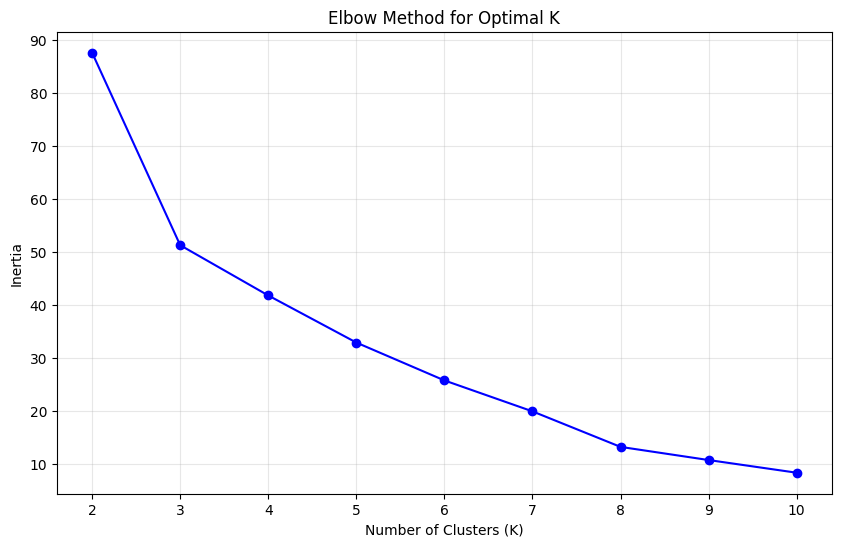

Elbow Method suggests optimal K = 9


In [ ]:
def elbow_method():
    """Find optimal K using the elbow method"""
    print("="*50)
    print("ELBOW METHOD ANALYSIS")
    print("="*50)
    
    k_range = range(2, 11)
    inertias = []
    seed = np.random.randint(0, 1000000) #42
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
        kmeans.fit(team_features_2d)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate the rate of change
    inertias_diff = np.diff(inertias)
    inertias_diff_rate = np.diff(inertias_diff)
    
    # Find the elbow point
    elbow_k = k_range[np.argmin(np.abs(inertias_diff_rate)) + 1]
    print(f"Elbow Method suggests optimal K = {elbow_k}")
    
    return inertias, elbow_k

inertias, k = elbow_method()

In [ ]:
# Perform clustering
seed = np.random.randint(0, 1000000)
print(f"Seed: {seed}")
kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed)
cluster_labels = kmeans.fit_predict(team_features_2d)

results_df = pd.DataFrame({
    'Team': team_names,
    'cluster': cluster_labels,
    'x_coord': team_features_2d[:, 0], 
    'y_coord': team_features_2d[:, 1]
})

print(results_df)


Seed: 117631
[4 8 7 7 5 1 2 0 1 1 6 0 6 6 5 3 2 3 1 6 2 3 6 3 1 6 0 4 1 1]
                      Team  cluster   x_coord   y_coord
0            Atlanta Hawks        4  3.707976 -1.084811
1           Boston Celtics        8 -3.619407  1.943927
2            Brooklyn Nets        7 -0.900699 -2.691583
3        Charlotte Hornets        7 -1.177953 -2.681397
4            Chicago Bulls        5  3.816096  1.297739
5      Cleveland Cavaliers        1 -0.229189 -1.176813
6         Dallas Mavericks        2 -0.155904  1.269471
7           Denver Nuggets        0  1.945865  1.126951
8          Detroit Pistons        1  0.887863 -0.653594
9    Golden State Warriors        1  0.698449 -1.218448
10         Houston Rockets        6 -1.120566  0.443591
11          Indiana Pacers        0  1.207034  1.452148
12             LA Clippers        6 -1.494270  1.576604
13      Los Angeles Lakers        6 -1.586764  1.049611
14       Memphis Grizzlies        5  3.812849  2.340869
15              Miami Heat   

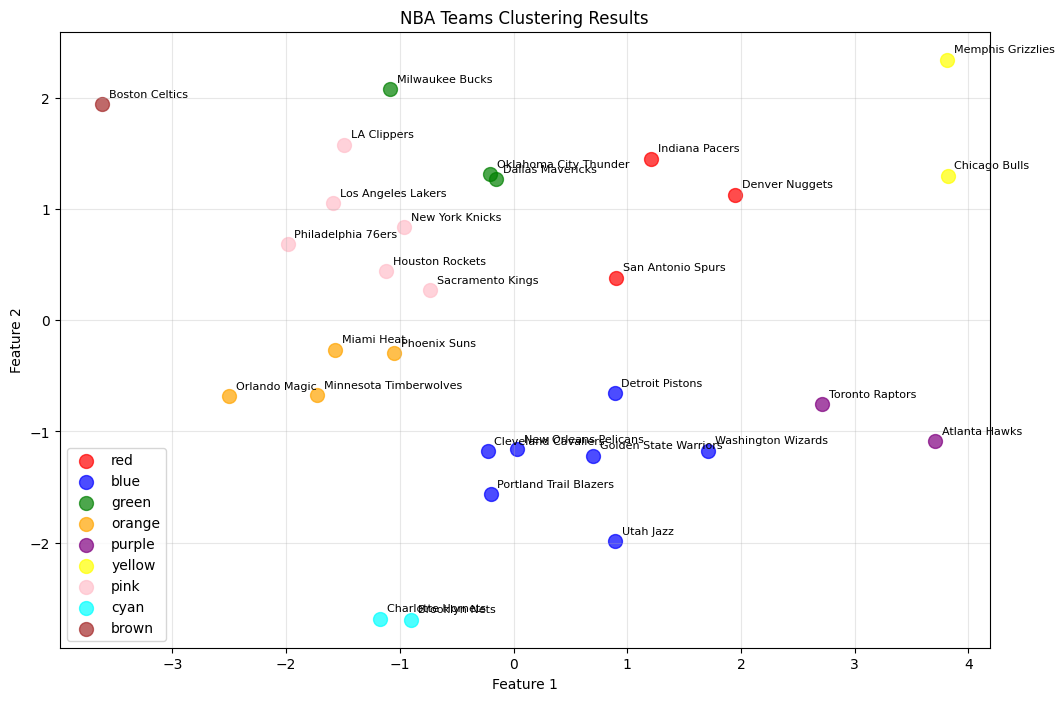

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink', 'cyan', 'brown']

plt.figure(figsize=(12, 8))
for cluster in range(k):
    cluster_data = results_df[results_df['cluster'] == cluster]
    plt.scatter(cluster_data['x_coord'], cluster_data['y_coord'], 
                c=colors[cluster], label=colors[cluster], alpha=0.7, s=100)

# Add team labels
for _, row in results_df.iterrows():
    plt.annotate(row['Team'], (row['x_coord'], row['y_coord']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.title('NBA Teams Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [128]:
for cluster_id in range(k):
    cluster_teams = results_df[results_df['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_teams)} teams):")
    print(f"  Teams: {', '.join(cluster_teams['Team'].tolist())}")
    
    # Get the team names in this cluster
    cluster_team_names = cluster_teams['Team'].tolist()
    
    # Get the stats for teams in this cluster from team_stats_sorted
    cluster_stats = team_stats_sorted[team_stats_sorted['team_name'].isin(cluster_team_names)]
    
    # Show average stats for this cluster
    print("  Average Stats:")
    for feature in features:
        avg_value = cluster_stats[feature].mean()
        print(f"    {feature}: {avg_value:.2f}")


Cluster 0 (3 teams):
  Teams: Denver Nuggets, Indiana Pacers, San Antonio Spurs
  Average Stats:
    turnover_rate: 0.14
    three_point_rate: 39.91
    assist_rate: 0.68
    offensive_rebound_percentage: 0.28
    pace: 100.50
    poss: 8300.00
    isolation_freq: 5.83
    transition_freq: 19.97
    pr_freq: 14.43
    handoff_freq: 4.97
    post_up_freq: 4.93

Cluster 1 (7 teams):
  Teams: Cleveland Cavaliers, Detroit Pistons, Golden State Warriors, New Orleans Pelicans, Portland Trail Blazers, Utah Jazz, Washington Wizards
  Average Stats:
    turnover_rate: 0.15
    three_point_rate: 42.97
    assist_rate: 0.64
    offensive_rebound_percentage: 0.30
    pace: 100.27
    poss: 8257.86
    isolation_freq: 6.11
    transition_freq: 18.39
    pr_freq: 17.30
    handoff_freq: 5.56
    post_up_freq: 2.24

Cluster 2 (3 teams):
  Teams: Dallas Mavericks, Milwaukee Bucks, Oklahoma City Thunder
  Average Stats:
    turnover_rate: 0.13
    three_point_rate: 41.08
    assist_rate: 0.60
    offe